In [6]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# 1) 데이터 로드하기
# 위의 링크로부터 전체 데이터에 해당하는 ratings_total.txt를 다운로드합니다.

urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x1c5e9f179a0>)

In [7]:
# 해당 데이터에는 열제목이 별도로 없습니다. 그래서 임의로 두 개의 열제목인 'ratings'와 'reviews'를 추가해주겠습니다.

total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [8]:
# 총 20만개의 샘플이 존재합니다. 상위 5개의 샘플만 출력해봅시다.

total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [9]:
# 2) 훈련 데이터와 테스트 데이터 분리하기
# 현재 갖고 있는 데이터는 레이블을 별도로 갖고있지 않습니다. 평점이 4, 5인 리뷰에는 레이블 1을, 평점이 1, 2인 리뷰에는 레이블 0을 부여합니다. 부여된 레이블은 새로 생성한 label이라는 열에 저장합니다.

total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [10]:
# 각 열에 대해서 중복을 제외한 샘플의 수를 카운트합니다.

total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [11]:
# ratings열의 경우 1, 2, 4, 5라는 네 가지 값을 가지고 있습니다. reviews열에서 중복을 제외한 경우 199,908개입니다. 현재 20만개의 리뷰가 존재하므로 이는 현재 갖고 있는 데이터에 중복인 샘플들이 있다는 의미입니다. 중복인 샘플들을 제거해줍니다.

total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [12]:
# NULL 값 유무를 확인합니다.

print(total_data.isnull().values.any())

False


In [13]:
# 훈련 데이터와 테스트 데이터를 3:1 비율로 분리합니다.

train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


   label  count
0      0  74918
1      1  75013


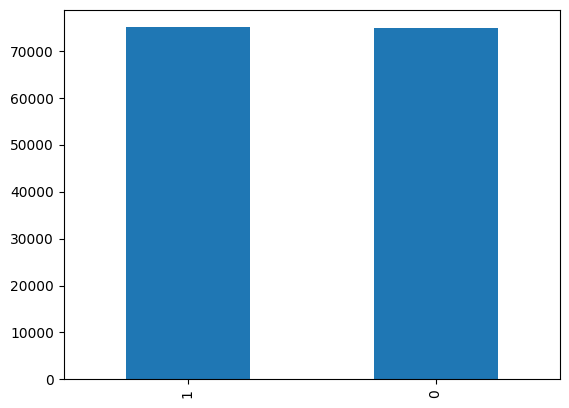

In [14]:
# 3) 레이블의 분포 확인
# 훈련 데이터의 레이블의 분포를 확인해봅시다.

train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

In [15]:
# 4) 데이터 정제하기
# 정규 표현식을 사용하여 한글을 제외하고 모두 제거해줍니다. 또한 혹시 이 과정에서 빈 샘플이 생기지는 않는지 확인합니다.

# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


C:\Users\505-07\AppData\Local\Temp\ipykernel_11188\3643266328.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [16]:
# 테스트 데이터에 대해서도 같은 과정을 거칩니다.

test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


C:\Users\505-07\AppData\Local\Temp\ipykernel_11188\3701147896.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [17]:
# 5) 토큰화
# 형태소 분석기 Okt을 사용하여 토큰화 작업을 수행합니다. 다음은 임의의 문장에 대해서 테스트한 토큰화 결과입니다.

okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [21]:
# 불용어를 지정하여 필요없는 토큰들은 제거하도록 합니다.
# 불용어 리스트 가져오기
f = open("stopword2.txt","r")
stopwords2 = []
while True:
    line = f.readline().strip()
    if not line: 
        break
    stopwords2.append(line)

stopwords3=['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
stopwords = stopwords2+stopwords3
print(stopwords)


['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를 들면', '예를 들자면', '저', '소인', '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다', '해서는 안된다', '뿐만 아니라', '만이 아니다', '만은 아니다', '막론하고', '관계없이', '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다', '따지지 않다', '설사', '비록', '더라도', '아니면', '만 못하다', '하는 편이 낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', '이 밖에', '하여야', '비로소', '한다면 몰라도', '외에도', '이곳', '여기', '부터', '기점으로', '따라서', '할 생각이다', '하려고하다', '이리하여', '그리하여', '그렇게 함으로써', '하지만', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', '임에 틀림없다', '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', '댕그', '대해서', '대하여', '대하면', '훨씬', '얼마나', '얼마만큼', '얼마큼', '남짓', '여', '얼마간', '약간', '다소', '좀', '조금', '다수', '몇', '얼마', '지만', '하물며', '또한', '그러나', '그렇지만', '하지만', '이외에도', '대해 말하자면', '뿐이다', '다음에', '반대로', '반대로 말하자면', '이와 반대로',

In [19]:
# 훈련 데이터와 테스트 데이터에 대해서 동일한 과정을 거칩니다.

train_data['tokenized'] = train_data['reviews'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

KeyboardInterrupt: 

In [21]:
# 6) 단어와 길이 분포 확인하기
# 긍정 리뷰에는 주로 어떤 단어들이 많이 등장하고, 부정 리뷰에는 주로 어떤 단어들이 등장하는지 두 가지 경우에 대해서 각 단어의 빈도수를 계산해보겠습니다. 각 레이블에 따라서 별도로 단어들의 리스트를 저장해줍니다.

negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [22]:
# Counter()를 사용하여 각 단어에 대한 빈도수를 카운트합니다. 우선 부정 리뷰에 대해서 빈도수가 높은 상위 20개 단어들을 출력합니다.

negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('너무', 13039), ('요', 11784), ('안', 11676), ('배송', 9171), ('그냥', 8518), ('잘', 7817), ('로', 5777), ('했는데', 5692), ('별로', 5549), ('못', 5174), ('제품', 5071), ('으로', 4999), ('생각', 4927), ('좀', 4878), ('사용', 4846), ('하고', 4769), ('ㅠㅠ', 4760), ('구매', 4634), ('보다', 4617), ('맛', 4017)]


In [23]:
# '네요', '는데', '안', '않', '너무', '없' 등과 같은 단어들이 부정 리뷰에서 주로 등장합니다. 긍정 리뷰에 대해서도 출력해봅시다.

positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('잘', 15302), ('좋아요', 14527), ('배송', 12251), ('너무', 9100), ('재구매', 8573), ('구매', 7186), ('요', 6639), ('사용', 5415), ('가격', 5015), ('으로', 4477), ('같아요', 4434), ('로', 4318), ('좋네요', 4221), ('빠르고', 4025), ('보다', 3955), ('제품', 3950), ('주문', 3815), ('입니다', 3769), ('생각', 3491), ('했어요', 3367)]


긍정 리뷰의 평균 길이 : 10.768613440337008
부정 리뷰의 평균 길이 : 14.101804639739449


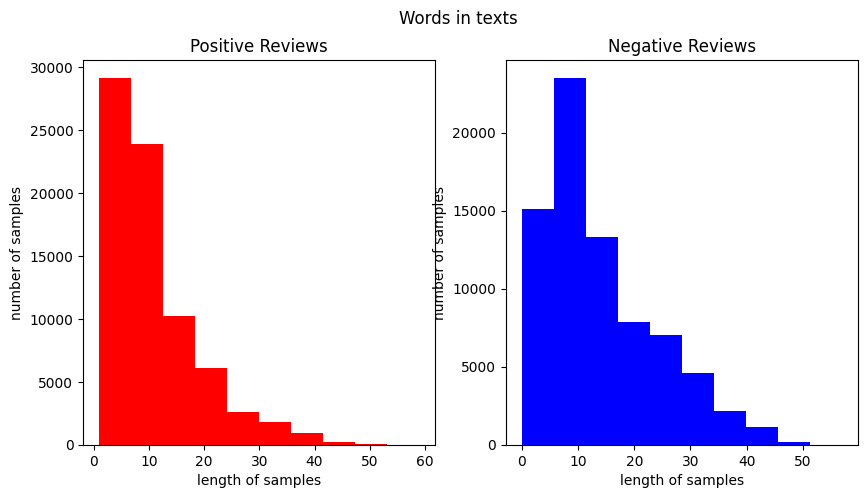

In [24]:
# '좋', '아요', '네요', '잘', '너무', '만족' 등과 같은 단어들이 주로 많이 등장합니다. 두 가지 경우에 대해서 각각 길이 분포를 확인해봅시다.

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [25]:
# 긍정 리뷰보다는 부정 리뷰가 좀 더 길게 작성된 경향이 있는 것 같습니다.

X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [26]:
# 7) 정수 인코딩
# 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다.

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [28]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 94361
등장 빈도가 1번 이하인 희귀 단어의 수: 52344
단어 집합에서 희귀 단어의 비율: 55.47207002893144
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.807755335212537


In [29]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 42019


In [30]:
# 단어 집합의 크기는 21,787개입니다. 이를 토크나이저의 인자로 넘겨주고, 텍스트 시퀀스를 정수 시퀀스로 변환합니다. 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환하겠습니다.

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# X_train과 X_test에 대해서 상위 3개의 샘플만 출력합니다.

print(X_train[:3])
print(X_test[:3])

[[33, 2263, 274, 1, 294, 174, 105, 78, 328, 5, 9212, 790, 5, 34, 25, 1637, 1036, 391, 92, 6], [2867, 1494, 4132, 3159, 3194, 260, 1, 1], [14, 139, 6114, 318, 2720, 504, 2, 7, 30070, 946, 52, 29, 100, 2995, 170, 504, 100, 2, 13635, 7396, 4010, 5, 69, 18012]]
[[3, 6886, 778, 2095, 151, 2214], [260, 7279, 25, 5281], [4, 714, 16, 96, 64, 32, 20, 496, 131, 1, 67, 2837, 2, 117]]


리뷰의 최대 길이 : 59
리뷰의 평균 길이 : 12.43415304373345


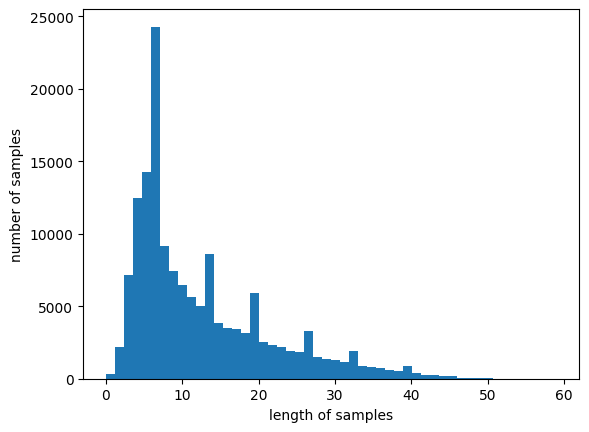

In [31]:
# 8) 패딩
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다. 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보겠습니다.

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [32]:
# 리뷰의 최대 길이는 85, 평균 길이는 약 15입니다. 그래프로 봤을 때, 전체적으로는 60이하의 길이를 가지는 것으로 보입니다.

def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [33]:
# 최대 길이가 85이므로 만약 80으로 패딩할 경우, 몇 개의 샘플들을 온전히 보전할 수 있는지 확인해봅시다.

max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 100.0


In [34]:
# 훈련용 리뷰의 99.99%가 80이하의 길이를 가집니다. 훈련용 리뷰를 길이 80으로 패딩하겠습니다.

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [35]:
# 3. GRU로 네이버 쇼핑 리뷰 감성 분류하기
# 하이퍼파라미터인 임베딩 벡터의 차원은 100, 은닉 상태의 크기는 128입니다. 
# 모델은 다 대 일 구조의 LSTM를 사용합니다. 
# 해당 모델은 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델입니다. 
# 이진 분류 문제의 경우, 출력층에 로지스틱 회귀를 사용해야 하므로 활성화 함수로는 시그모이드 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용합니다. 
# 하이퍼파라미터인 배치 크기는 64이며, 15 에포크를 수행합니다.

# EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)는 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 정해진 에포크가 
# 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)한다는 의미입니다. ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다.
# validation_split=0.2을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용하고, 검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인합니다. 
# 검증 데이터는 기계가 훈련 데이터에 과적합되고 있지는 않은지 확인하기 위한 용도로 사용됩니다.

from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.2753 - acc: 0.8941
Epoch 1: val_acc improved from -inf to 0.91250, saving model to best_model.h5
1875/1875 [==============================] - 137s 72ms/step - loss: 0.2753 - acc: 0.8941 - val_loss: 0.2345 - val_acc: 0.9125
Epoch 2/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.2188 - acc: 0.9209
Epoch 2: val_acc improved from 0.91250 to 0.91840, saving model to best_model.h5
1875/1875 [==============================] - 138s 74ms/step - loss: 0.2188 - acc: 0.9209 - val_loss: 0.2246 - val_acc: 0.9184
Epoch 3/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.1983 - acc: 0.9297
Epoch 3: val_acc improved from 0.91840 to 0.92037, saving model to best_model.h5
1875/1875 [==============================] - 137s 73ms/step - loss: 0.1983 - acc: 0.9297 - val_loss: 0.2183 - val_acc: 0.9204
Epoch 4/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.1836 - acc: 0.9362
Epoch 4: v

In [2]:
# 저자의 경우 에포크 10에서 조기 종료가 발생했습니다.

loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

NameError: name 'load_model' is not defined

In [37]:
# 4. 리뷰 예측해보기
# 임의의 문장에 대한 예측을 위해서는 학습하기 전 전처리를 동일하게 적용해줍니다. 전처리의 순서는 정규 표현식을 통한 한국어 외 문자 제거, 토큰화, 불용어 제거, 정수 인코딩, 패딩 순입니다.
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [40]:
sentiment_predict('참치 찌게랑 주먹밥에 사용해봤는데 오래된 제품인지 푸석거리고 내용물이 다 으스러져있고 싱싱한 느낌 거의 없어요. 주문하고 싶지 않다는 생각들어요.ㅜㅜ')

1/1 [==============================] - 0s 16ms/step
99.02% 확률로 긍정 리뷰입니다.
